# PREDICTING HOUSING PRICES

---
# Introduction

In this project, we will go through the iterative process of specifying, fitting, and analyzing the performance of a **linear** model.  

In the first portion of the project, we will process some basic exploratory data analysis (EDA), laying out the thought process that leads to certain modeling decisions. Next, we will add a new feature to the dataset, before specifying and fitting a linear model to a few features of the housing data to predict housing prices. Finally, we will analyze the error of the model and brainstorm ways to improve the model's performance.

---
# Set up the Environment

In [1]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

---
# The Data

The [Ames dataset](http://jse.amstat.org/v19n3/decock.pdf) consists of 2930 records taken from the Ames, Iowa, Assessor’s Office describing houses sold in Ames from 2006 to 2010.  The data set has 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables (and 2 additional observation identifiers) --- 82 features in total.  An explanation of each variable can be found in the included `codebook.txt` file.  The information was used in computing assessed values for individual residential properties sold in Ames, Iowa from 2006 to 2010.  **Some noise has been added to the actual sale price, so prices will not match official records.**

The data are split into training and test sets with 2000 and 930 observations, respectively.

In [2]:
training_data = pd.read_csv("ames_train.csv")
test_data = pd.read_csv("ames_test.csv")

As a good sanity check, we verify that the data shape matches the description.

In [3]:
# 2000 observations and 82 features in training data
assert training_data.shape == (2000, 82)

# 930 observations and 81 features in test data
assert test_data.shape == (930, 81)

# SalePrice is hidden in the test data
assert 'SalePrice' not in test_data.columns.values

# Every other column in the test data should be in the training data
assert len(np.intersect1d(test_data.columns.values, 
                          training_data.columns.values)) == 81

The next order of business is getting a feel for the variables in our data.  The Ames data set contains information that typical homebuyers would want to know.  A more detailed description of each variable is included in `codebook.txt`.

In [4]:
training_data.columns.values

array(['Order', 'PID', 'MS_SubClass', 'MS_Zoning', 'Lot_Frontage',
       'Lot_Area', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour',
       'Utilities', 'Lot_Config', 'Land_Slope', 'Neighborhood',
       'Condition_1', 'Condition_2', 'Bldg_Type', 'House_Style',
       'Overall_Qual', 'Overall_Cond', 'Year_Built', 'Year_Remod/Add',
       'Roof_Style', 'Roof_Matl', 'Exterior_1st', 'Exterior_2nd',
       'Mas_Vnr_Type', 'Mas_Vnr_Area', 'Exter_Qual', 'Exter_Cond',
       'Foundation', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure',
       'BsmtFin_Type_1', 'BsmtFin_SF_1', 'BsmtFin_Type_2', 'BsmtFin_SF_2',
       'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Heating', 'Heating_QC',
       'Central_Air', 'Electrical', '1st_Flr_SF', '2nd_Flr_SF',
       'Low_Qual_Fin_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr',
       'Kitchen_AbvGr', 'Kitchen_Qual', 'TotRms_AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace_Qu', 'Garage_Type', 'Garage_Yr_Blt',

---
# Part I - Exploratory Data Analysis

In this section, we will make a series of exploratory visualizations and interpret them.

Note that we will perform EDA on the **training data** so that information from the test data does not influence our modeling decisions.

### I. 1) Sale Price

We begin by examining a [raincloud plot](https://micahallen.org/2018/03/15/introducing-raincloud-plots/amp/?__twitter_impression=true) (a combination of a KDE, a histogram, a strip plot, and a box plot) of our target variable `SalePrice`).  At the same time, we also take a look at some descriptive statistics of this variable.

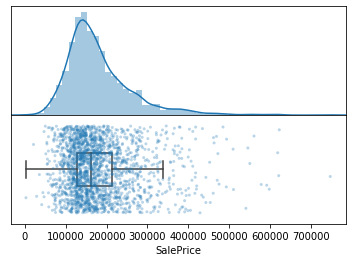

In [5]:
fig, axs = plt.subplots(nrows=2)

sns.distplot(
    training_data['SalePrice'], 
    ax=axs[0]
)
sns.stripplot(
    training_data['SalePrice'], 
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    training_data['SalePrice'],
    width=0.3, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(training_data['SalePrice']) * 0.05
xmin = np.min(training_data['SalePrice']) - spacer
xmax = np.max(training_data['SalePrice']) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].artists[0].set_facecolor('white')

In [6]:
training_data['SalePrice'].describe()

count      2000.000000
mean     180775.897500
std       81581.671741
min        2489.000000
25%      128600.000000
50%      162000.000000
75%      213125.000000
max      747800.000000
Name: SalePrice, dtype: float64

### I. 2) Statistics

To check our understanding of the graph and summary statistics above, we notice the following remarks:

1. The distribution of `SalePrice` in the training set is right-skew.
1. The mean of `SalePrice` in the training set is greater than the median.
1. At least 25% of the houses in the training set sold for more than \$200,000.00.

### I. 3) SalePrice vs Gr_Liv_Area

Next, we visualize the association between `SalePrice` and `Gr_Liv_Area`.  The `codebook.txt` file tells us that `Gr_Liv_Area` measures "above grade (ground) living area square feet."

This variable represents the square footage of the house excluding anything underground. Some additional research (into real estate conventions) reveals that this value also excludes the garage space.

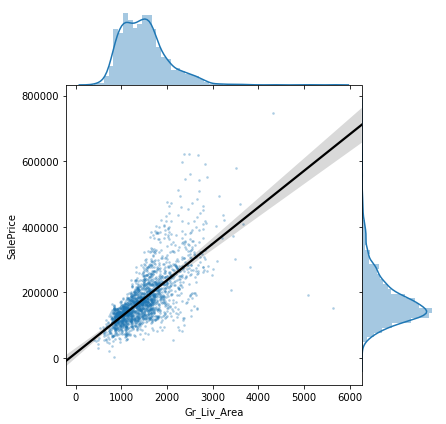

In [7]:
sns.jointplot(
    x='Gr_Liv_Area', 
    y='SalePrice', 
    data=training_data,
    stat_func=None,
    kind="reg",
    ratio=4,
    space=0,
    scatter_kws={
        's': 3,
        'alpha': 0.25
    },
    line_kws={
        'color': 'black'
    }
);

There's certainly an association, and perhaps it's linear, but the spread is wider at larger values of both variables.  Also, there are two particularly suspicious houses above 5000 square feet that look too inexpensive for their size.

The Parcel Indentification Numbers for the two houses with `Gr_Liv_Area` greater than 5000 sqft are:

In [8]:
training_data.loc[training_data['Gr_Liv_Area'] > 4900, 'PID'].values

array([908154235, 908154195], dtype=int64)

### I. 4) Remove outliers

The codebook tells us how to manually inspect the houses using an online database called Beacon. These two houses are true outliers in this data set: they aren't the same time of entity as the rest. They were partial sales, priced far below market value. If you would like to inspect the valuations, follow the directions at the bottom of the codebook to access Beacon and look up houses by PID.

For this project, we will remove these outliers from the data. We will write a function `remove_outliers` that removes outliers from a data set based off a threshold value of a variable.  For example, `remove_outliers(training_data, 'Gr_Liv_Area', upper=5000)` should return a data frame with only observations that satisfy `Gr_Liv_Area` less than or equal to 5000.

In [9]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a winsorized data frame with outliers removed
    """  
    return data.loc[(lower < data[variable]) & (data[variable] < upper), :]

In [10]:
training_data = remove_outliers(training_data, 'Gr_Liv_Area', upper=5000)

---
# Part II - Feature Engineering

In this section we will create a new feature out of existing ones through a simple data transformation.

### II. 1) Bathrooms

Let's create a groundbreaking new feature. Due to recent advances in Universal WC Enumeration Theory, we now know that Total Bathrooms can be calculated as:

$$ \text{TotalBathrooms}=(\text{BsmtFullBath} + \text{FullBath}) + \dfrac{1}{2}(\text{BsmtHalfBath} + \text{HalfBath})$$

We will use this result in our model: we will write a function `add_total_bathrooms(data)` that returns a copy of `data` with an additional column called `TotalBathrooms` computed by the formula above.

*Note: we treat missing values as zeros*.

In [11]:
def add_total_bathrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least 4 numeric columns 
            Bsmt_Full_Bath, Full_Bath, Bsmt_Half_Bath, and Half_Bath
            
    Output:
      a new data frame with a new column TotalBathrooms
    """
    with_bathrooms = data.copy()
    bath_vars = ['Bsmt_Full_Bath', 'Full_Bath', 'Bsmt_Half_Bath', 'Half_Bath']
    weights = pd.Series([1, 1, 0.5, 0.5], index=bath_vars)
    
    with_bathrooms['TotalBathrooms'] = (with_bathrooms[bath_vars].fillna(0).mul(weights)).sum(axis=1)
    
    return with_bathrooms

In [12]:
training_data = add_total_bathrooms(training_data)

### II. 2) Visualization

We create a visualization that clearly and succintly shows that `TotalBathrooms` is associated with `SalePrice`. We want to avoid overplotting.

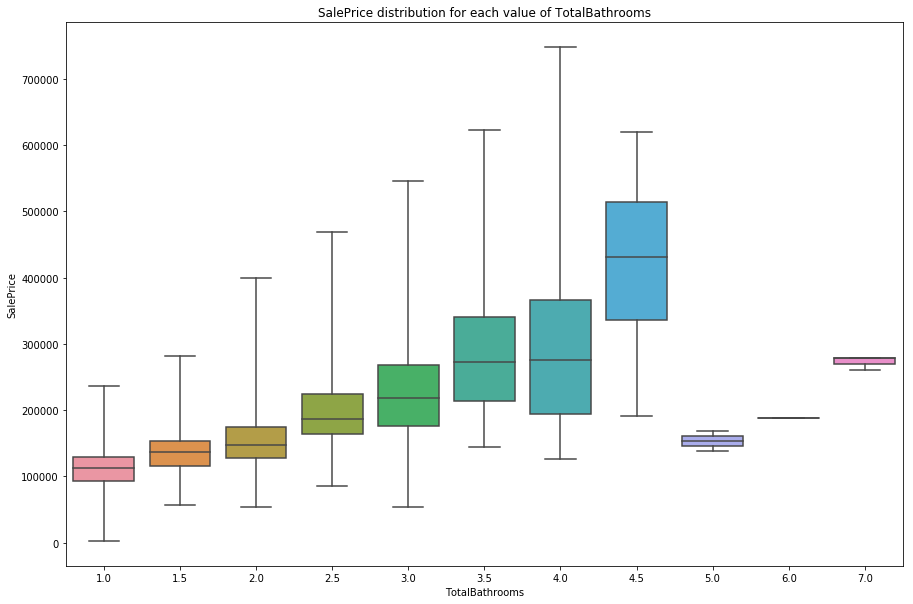

In [13]:
plt.figure(figsize=(15,10))
sns.boxplot(x = 'TotalBathrooms', y = 'SalePrice', data = training_data, whis=5)
plt.title('SalePrice distribution for each value of TotalBathrooms');

---
# Part III - Modeling

We've reached the point where we can specify a model. But first, we will load a fresh copy of the data, just in case our code above produced any undesired side-effects. Run the cell below to store a fresh copy of the data from `ames_train.csv` in a dataframe named `full_data`. We will also store the number of rows in `full_data` in the variable `full_data_len`.

In [14]:
# Load a fresh copy of the data and get its length
full_data = pd.read_csv("ames_train.csv")
full_data_len = len(full_data)
print(full_data_len)
full_data.head()

2000


,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,204900
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,95300
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,181900
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,254100
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,199700


### III. 1) Split the data

Now, let's split the data set into a training set and test set. We will use the training set to fit our model's parameters, and we will use the test set to estimate how well our model will perform on unseen data drawn from the same distribution. If we used all the data to fit our model, we would not have a way to estimate model performance on unseen data.

"Don't we already have a test set in `ames_test.csv`?" you might wonder. The sale prices for `ames_test.csv` aren't provided, so we're constructing our own test set for which we know the outputs.

In the cell below, we split the data in `full_data` into two DataFrames named `train` and `test`. Let `train` contain 80% of the data, and let `test` contain the remaining 20% of the data. 

To do this, we first create two NumPy arrays named `train_indices` and `test_indices`. `train_indices` will contain a *random* 80% of the indices in `full_data`, and `test_indices` will contain the remaining 20% of the indices. Then, we use these arrays to index into `full_data` to create the final `train` and `test` DataFrames.

In [15]:
# This makes the train-test split in this section reproducible across different runs of the notebook.
np.random.seed(1337)
shuffled_indices = np.random.permutation(full_data_len)

# Set train_indices to the first 80% of shuffled_indices and and test_indices to the rest.
train_indices = shuffled_indices[:int(0.8*full_data_len)]
test_indices = shuffled_indices[int(0.8*full_data_len):]

# Create train and test` by indexing into `full_data` using `train_indices` and `test_indices`
train = full_data.iloc[train_indices]
test = full_data.iloc[test_indices]

### III. 2) Reusable Pipeline

Throughout this project, we notice that the data flows through a single processing pipeline several times.  From a software engineering perspective, it's best to define functions/methods that can apply the pipeline to any dataset.  We will now encapsulate our entire pipeline into a single function `process_data_gm`. gm is shorthand for "guided model". We select a handful of features to use from the many that are available.

In [16]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def process_data_gm(data):
    """Process the data for a guided model."""
    data = remove_outliers(data, 'Gr_Liv_Area', upper=5000)
    
    # Transform Data, Select Features
    data = add_total_bathrooms(data)
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                          'TotalBathrooms',
                         )
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    
    return X, y

Now, we can use `process_data_gm1` to clean our data, select features, and add our `TotalBathrooms` feature all in one step! This function also splits our data into `X`, a matrix of features, and `y`, a vector of sale prices. 

We run the cell below to feed our training and test data through the pipeline, generating `X_train`, `y_train`, `X_test`, and `y_test`.

In [17]:
# Pre-process our training and test data in exactly the same way
# Our functions make this very easy!

X_train, y_train = process_data_gm(train)
X_test, y_test = process_data_gm(test)

### III. 3) Fitting Our First Model

We are finally going to fit a model!  The model we will fit can be written as follows:

$$\text{SalePrice} = \theta_0 + \theta_1 \cdot \text{Gr_Liv_Area} + \theta_2 \cdot \text{Garage_Area} + \theta_3 \cdot \text{TotalBathrooms}$$

In vector notation, the same equation would be written:

$$y = \vec\theta \cdot \vec{x}$$

where $y$ is the SalePrice, $\vec\theta$ is a vector of all fitted weights, and $\vec{x}$ contains a 1 for the bias followed by each of the feature values.

**Note:** Notice that all of our variables are continuous, except for `TotalBathrooms`, which takes on discrete ordered values (0, 0.5, 1, 1.5, ...). In this project, we'll treat `TotalBathrooms` as a continuous quantitative variable in our model, but this might not be the best choice.

We will use a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object as our linear model. In the cell below, we create a `LinearRegression` object and name it `linear_model`.

In [18]:
from sklearn import linear_model as lm

linear_model = lm.LinearRegression(fit_intercept=True)
linear_model.fit(X_train, y_train)
y_fitted = linear_model.predict(X_train)
y_predicted = linear_model.predict(X_test)

### III. 4) RMSE

Is our linear model any good at predicting house prices? Let's measure the quality of our model by calculating the Root-Mean-Square Error (RMSE) between our predicted house prices and the true prices stored in `SalePrice`.

$$\text{RMSE} = \sqrt{\dfrac{\sum_{\text{houses in test set}}(\text{actual price of house} - \text{predicted price of house})^2}{\text{# of houses in data set}}}$$

In the cell below, we write a function named `rmse` that calculates the RMSE of a model.

In [19]:
def rmse(actual, predicted):
    """
    Calculates RMSE from actual and predicted values
    Input:
      actual (1D array): vector of actual values
      predicted (1D array): vector of predicted/fitted values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

Now we use our `rmse` function to calculate the training error and test error in the cell below.

In [20]:
training_error = rmse(y_fitted, y_train)
test_error = rmse(y_predicted, y_test)

print("Training RMSE: {}\nTest RMSE: {}".format(training_error, test_error))

Training RMSE: 46710.597505875914
Test RMSE: 46146.64265682625


### III. 5) Evaluate the importance of the feature Total Bathrooms

How much does including `TotalBathrooms` as a predictor reduce the RMSE of the model on the test set? That is, what's the difference between the RSME of a model that only includes `Gr_Liv_Area` and `Garage_Area` versus one that includes all three predictors?

In [21]:
X_train_no_bath = X_train.loc[:, :'Garage_Area']

linear_model.fit(X_train_no_bath, y_train)
y_predicted_no_bath = linear_model.predict(X_test.loc[:, :'Garage_Area'])
test_error_no_bath = rmse(y_predicted_no_bath, y_test)

test_error_difference = test_error_no_bath - test_error
test_error_difference

2477.0084636470347

### III. 6) Residual Plots

One way of understanding the performance (and appropriateness) of a model is through a residual plot. We run the cell below to plot the actual sale prices against the residuals of the model for the test data.

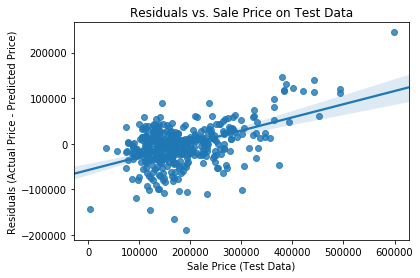

In [22]:
residuals = y_test - y_predicted
ax = sns.regplot(y_test, residuals)
ax.set_xlabel('Sale Price (Test Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')
ax.set_title("Residuals vs. Sale Price on Test Data");

Ideally, we would see a horizontal line of points at 0 (perfect prediction!). The next best thing would be a homogenous set of points centered at 0. 

But alas, our simple model is probably too simple. The most expensive homes are systematically more expensive than our prediction. 

### III. 7) Improvements

What changes could we make to your linear model to improve its accuracy and lower the test error?
- We could add more features that are likely to correlate with expensive houses. 
- We could also encode the neighborhoods as features, as houses from the same neighborhood might be closer in price. 
- We could also introduce regularization to improve our model.


### III. 8) Next steps

The linear model that we created failed to produce accurate estimates of the observed housing prices because the model was too simple. The goal of the next steps is to accomplish the iterative process of specifying, fitting, and analyzing the performance of more complex linear models used to predict prices of houses in Ames, Iowa. Additionally, we will have the opportunity to choose our own features and create our own regression model!

---
# Part IV - More Feature Selection and Engineering

In this section, we identify two more features of the dataset that will increase our linear regression model's accuracy. Additionally, we will implement one-hot encoding so that we can include binary and categorical variables in our improved model.

### IV. 1) Neighborhood vs Sale Price

First, let's take a look at the relationship between neighborhood and sale prices of the houses in our data set `training_data`.

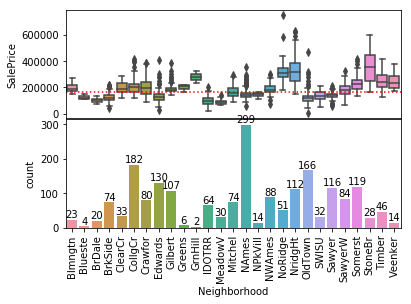

In [23]:
fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x='Neighborhood',
    y='SalePrice',
    data=training_data.sort_values('Neighborhood'),
    ax=axs[0]
)

sns.countplot(
    x='Neighborhood',
    data=training_data.sort_values('Neighborhood'),
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y=training_data['SalePrice'].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.01)

It is clear that there is quite some variation in prices across neighborhoods. Moreover, the amount of data available is not uniformly distributed among neighborhoods.  North Ames, for example, comprises almost 15% of the training data while Green Hill has a scant 2 observations in this data set.

### IV. 2) A new feature

One way we can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together. Let's categorize our neighborhoods in a crude way: we'll take the top 3 neighborhoods measured by median `SalePrice` and identify them as "rich neighborhoods"; the other neighborhoods are not marked.

##### IV. 2) a) Find the rich Neighborhoods

We will write a function that returns list of the top n most pricy neighborhoods as measured by our choice of aggregating function. For example, in the setup above, we would want to call `find_rich_neighborhoods(training_data, 3, np.median)` to find the top 3 neighborhoods measured by median `SalePrice`.

In [24]:
def find_rich_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (data frame): should contain at least a string-valued Neighborhood
        and a numeric SalePrice column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the top n richest neighborhoods as measured by the metric function
    """
    rich_neighborhoods = list(
        data.loc[:,['Neighborhood', 'SalePrice']].groupby('Neighborhood').aggregate(metric)
        .sort_values('SalePrice', ascending = False).head(n).index
    )
    
    return rich_neighborhoods

In [25]:
rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
rich_neighborhoods

['StoneBr', 'NridgHt', 'NoRidge']

##### IV. 2) b) Add an indicator

We now have a list of neighborhoods we've deemed as richer than others.  Let's use that information to make a new variable `in_rich_neighborhood`.  We will write a function `add_rich_neighborhood` that adds an indicator variable which takes on the value 1 if the house is part of `rich_neighborhoods` and the value 0 otherwise.

In [26]:
def add_in_rich_neighborhood(data, rich_neighborhoods):
    """
    Input:
      - data (data frame): a data frame containing a 'Neighborhood' column with values found in the codebook
      - rich_neighborhoods (list of strings): strings should be the names of neighborhoods pre-identified as rich
        
    Output:
      data frame identical to the input with the addition of a binary
      in_rich_neighborhood column
    """
    data['in_rich_neighborhood'] = (data['Neighborhood'].isin(rich_neighborhoods)).astype('int32')
    
    return data

In [27]:
training_data = add_in_rich_neighborhood(training_data, rich_neighborhoods)
training_data.head()

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice,TotalBathrooms,in_rich_neighborhood
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,NaN,NaN,0,5,2010,WD,Normal,204900,2.0,0
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,MnPrv,NaN,0,6,2010,WD,Normal,95300,1.0,0
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,NaN,Gar2,12500,6,2010,WD,Normal,181900,1.5,0
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,NaN,NaN,0,4,2010,WD,Normal,254100,3.5,0
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,MnPrv,NaN,0,3,2010,WD,Normal,199700,2.5,0


### IV. 3) Fireplace Quality

In the following part, we will take a closer look at the Fireplace_Qu feature of the dataset and examine how we can incorporate categorical features into our linear model.

##### IV. 3) a) Missing values

Let's see if our data set has any missing values.  We will create a Series object containing the counts of missing values in each of the columns of our data set, sorted from greatest to least.  The Series will be indexed by the variable names.

In [28]:
missing_counts = training_data.isnull().sum().sort_values(ascending = False)
missing_counts.head()

Pool_QC         1991
Misc_Feature    1922
Alley           1865
Fence           1607
Fireplace_Qu     975
dtype: int64

It turns out that if we look at the codebook carefully, some of these "missing values" aren't missing at all! The Assessor's Office just used `NA` to denote a special value or that the information was truly not applicable for one reason or another.  One such example is the `Fireplace_Qu` variable.

```
FireplaceQu (Ordinal): Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace inbasement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
```

##### IV. 3) b) Missing Values and Fireplace

An `NA` here actually means that the house had no fireplace to rate.  Let's fix this in our data set.  We write a function that replaces the missing values in `Fireplace_Qu` with `'No Fireplace'`.  In addition, it will replace each abbreviated condition with its full word.  For example, `'TA'` will be changed to `'Average'`.

In [29]:
def fix_fireplace_qu(data):
    """
    Input:
      data (data frame): a data frame containing a Fireplace_Qu column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored Fireplace_Qu column
    """
    dic = {
        'Ex': 'Excellent',
        'Gd': 'Good',
        'TA': 'Average',
        'Fa': 'Fair',
        'Po': 'Poor',
        np.nan: 'No Fireplace'
    }
    
    data['Fireplace_Qu'] = data['Fireplace_Qu'].replace(dic)
    
    return data

In [30]:
training_data = fix_fireplace_qu(training_data)

##### IV. 3) c) An Important Note on One Hot Encoding

Unfortunately, simply fixing these missing values isn't sufficient for using `Fireplace_Qu` in our model.  Since `Fireplace_Qu` is a categorical variable, we will have to one-hot-encode the data. 

In [31]:
def ohe_fireplace_qu(data):
    """
    One-hot-encodes fireplace quality.  New columns are of the form fpq_QUALITY
    """
    cats = [
        'Excellent',
        'Good',
        'Average',
        'Fair',
        'Poor',
        'No Fireplace'
    ]
    
    cat_type = CategoricalDtype(categories=cats)
    
    data.loc[:, 'Fireplace_Qu'] = data.loc[:, 'Fireplace_Qu'].astype(cat_type)
    data = pd.get_dummies(data,
                          prefix='fpq',
                          columns=['Fireplace_Qu'], 
                          drop_first=True)
    
    return data

In [32]:
training_data = ohe_fireplace_qu(training_data)
training_data.filter(regex='fpq').head(10)

,fpq_Good,fpq_Average,fpq_Fair,fpq_Poor,fpq_No Fireplace
0,1,0,0,0,0
1,0,0,0,0,1
2,0,0,0,0,1
3,0,1,0,0,0
4,0,1,0,0,0
5,1,0,0,0,0
6,0,0,0,0,1
7,0,1,0,0,0
8,0,0,0,0,1
9,1,0,0,0,0


In [33]:
training_data.head()

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Sale_Type,Sale_Condition,SalePrice,TotalBathrooms,in_rich_neighborhood,fpq_Good,fpq_Average,fpq_Fair,fpq_Poor,fpq_No Fireplace
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,WD,Normal,204900,2.0,0,1,0,0,0,0
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,WD,Normal,95300,1.0,0,0,0,0,0,1
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,WD,Normal,181900,1.5,0,0,0,0,0,1
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,WD,Normal,254100,3.5,0,0,1,0,0,0
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,WD,Normal,199700,2.5,0,0,1,0,0,0


---
# Part V - Improved Linear Models

In this section, we will create linear models that produce more accurate estimates of the housing prices in Ames than the previous model , but at the expense of increased complexity.

### V. 1) Adding Covariates to our Model

It's finally time to fit our updated linear regression model using the ordinary least squares estimator! Our new model consists of the initial linear model, with the addition of the newly created `in_rich_neighborhood` variable and our one-hot-encoded fireplace quality variables:

$$\begin{align}
\text{SalePrice} & = \theta_0 + \theta_1 \cdot \text{Gr_Liv_Area} + \theta_2 \cdot \text{Garage_Area} + 
\theta_3 \cdot \text{TotalBathrooms} + \theta_4 \cdot \text{in_rich_neighborhood} + \\
& \quad \: \theta_5 \cdot \text{fpq_Good} + \theta_6 \cdot \text{fpq_Average} + \theta_7 \cdot \text{fpq_Fair} +
\theta_8 \cdot \text{fpq_Poor} + \theta_9 \cdot \text{fpq_No_Fireplace}
\end{align}$$

### V. 2) Train and test indices

First, we will re-import the data and split `training_data` into a training and test set.

In [34]:
training_data = pd.read_csv("ames_train.csv")
test_data = pd.read_csv("ames_test.csv")

training_data_len = len(training_data)

In [35]:
# This makes the train-test split in this section reproducible across different runs of the notebook.
np.random.seed(1337)
shuffled_indices = np.random.permutation(training_data_len)

# Set train_indices to the first 80% of shuffled_indices and and test_indices to the rest.
train_indices = shuffled_indices[:int(0.8*training_data_len)]
test_indices = shuffled_indices[int(0.8*training_data_len):]

# Create train and test` by indexing into `full_data` using `train_indices` and `test_indices`
train = training_data.iloc[train_indices]
test = training_data.iloc[test_indices]

### V. 3) Reusable pipeline

Next, we will implement a reusable pipeline that selects the required variables in our data and splits our covariates and response variable into a matrix and a vector, respectively.

In [36]:
def process_data_gm_v2(data):
    """Process the data for a guided model."""
    # Remove Outliers
    data = remove_outliers(data, 'Gr_Liv_Area', upper=5000)
    
    # Add total bathrooms
    data = add_total_bathrooms(data)
    
    # One-hot-encode fireplace quality feature
    data = fix_fireplace_qu(data)
    data = ohe_fireplace_qu(data)
    
    # Use rich_neighborhoods computed earlier to add in_rich_neighborhoods feature
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    
    # Transform Data, Select Features
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                          'TotalBathrooms',
                          'in_rich_neighborhood',
                          'fpq_Good',
                          'fpq_Average',
                          'fpq_Fair',
                          'fpq_Poor',
                          'fpq_No Fireplace',
                         )
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    
    return X, y

### V. 4) Training and Test Datasets

We then split our dataset into training and testing sets using our data cleaning pipeline.

In [37]:
# Pre-process our training and test data in exactly the same way
# Our functions make this very easy!
X_train, y_train = process_data_gm_v2(train)
X_test, y_test = process_data_gm_v2(test)

### V. 5) Build the model

Finally, we initialize a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object as our linear model. We set the `fit_intercept = True` to ensure that the linear model has a non-zero intercept.

In [38]:
from sklearn import linear_model as lm

linear_model = lm.LinearRegression(fit_intercept=True)

# Fit the model below
linear_model.fit(X_train, y_train) 

# Compute the fitted and predicted values of SalePrice
y_fitted = linear_model.predict(X_train) 
y_predicted = linear_model.predict(X_test)

### V. 6) RMSE

Now use your `rmse` function to calculate the training error and test error in the cell below.

In [39]:
training_error = rmse(y_fitted, y_train) 
test_error = rmse(y_predicted, y_test)

print("Training RMSE: {}\nTest RMSE: {}".format(training_error, test_error))

Training RMSE: 40524.01538812723
Test RMSE: 38568.82050962115


The test RMSE of the new model's predictions is 38754.8606, and the initial test RMSE is 46146.643. Therefore, we conclude that our new model is more accurate. However, the relative change of RMSE between models is $\approx 16\%$. Since we know that the original model did a poor job of predicting house sale prices, this signifies that there is a lot of room for improvement.

---
# Part VI - More one-hot encoding for a better accuracy

The goal in this last part is to provide a linear regression model that accurately predicts the prices of the held-out homes, measured by root mean square error.

### VI. 1) Final guided model

We create the final guided model function:

In [40]:
final_model = lm.LinearRegression(fit_intercept=True)

def process_data_fm(data):
    """Process the data for a guided model."""
    # Remove Outliers
    data = remove_outliers(data, 'Gr_Liv_Area', upper=5000)
    
    # Add total bathrooms
    data = add_total_bathrooms(data)
    
    # One-hot-encode fireplace quality feature
    data = fix_fireplace_qu(data)
    data = ohe_fireplace_qu(data)
    
    # Use rich_neighborhoods computed earlier to add in_rich_neighborhoods feature
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
        
    # Select the features
    data = select_columns(data,
                          'SalePrice',
                          'Gr_Liv_Area',
                          'Garage_Area',
                          'TotalBathrooms',
                          'in_rich_neighborhood',
                          'fpq_Good',
                          'fpq_Average',
                          'fpq_Fair',
                          'fpq_Poor',
                          'fpq_No Fireplace',
                          'Overall_Qual',
                          'Land_Contour',
                          'Condition_1',
                          'Bldg_Type',
                          'Year_Built',
                          'Total_Bsmt_SF'
                         )
    
    # Convert the variables into dummies
    data = pd.get_dummies(data,
                          prefix='land_',
                          columns=['Land_Contour'],
                          drop_first=True) 
    data = pd.get_dummies(data,
                          prefix='cond',
                          columns=['Condition_1'],
                          drop_first=True)
    data = pd.get_dummies(data,
                          prefix='bldg',
                          columns=['Bldg_Type'],
                          drop_first=True)
    
    # Fill the NA values
    data.fillna(0, inplace=True)
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    
    return X, y

### VI. 2) Build the model

We build the final model of prediction

In [41]:
training_data = pd.read_csv("ames_train.csv")
test_data = pd.read_csv("ames_test.csv")
training_data_len = len(training_data)

In [42]:
# This makes the train-test split in this section reproducible across different runs of the notebook.
np.random.seed(1337)
shuffled_indices = np.random.permutation(training_data_len)

# Set train_indices to the first 80% of shuffled_indices and and test_indices to the rest.
train_indices = shuffled_indices[:int(0.8*training_data_len)]
test_indices = shuffled_indices[int(0.8*training_data_len):]

# Create train and test` by indexing into `full_data` using `train_indices` and `test_indices`
train = training_data.iloc[train_indices]
test = training_data.iloc[test_indices]

In [43]:
# Pre-process our training and test data in exactly the same way
# Our functions make this very easy!
X_train, y_train = process_data_fm(train)
X_test, y_test = process_data_fm(test)

In [44]:
final_model.fit(X_train, y_train)

y_predicted_train = final_model.predict(X_train)
y_predicted_test = final_model.predict(X_test)

### VI. 3) RMSE

Now we use our `rmse` function to calculate the training error and test error in the cell below.

In [45]:
training_rmse = rmse(y_predicted_train, y_train)
test_rmse = rmse(y_predicted_test, y_test)

print("Training RMSE: {}\nTest RMSE: {}".format(training_rmse, test_rmse))

Training RMSE: 31243.08163663193
Test RMSE: 28903.594196925038


The test RMSE of the new model's predictions is now 31243.0816, and the initial test RMSE is 46146.643. Therefore, we conclude that our new model is more accurate. The relative change of RMSE between models is $\approx 35\%$. 

The RMSE can still be improved by adding more relevant features and by chosing a different model (non linear).